# Testing Tomato Leaf Disease Detection Models

This notebook focuses on testing and evaluating the different YOLO models trained for tomato leaf disease detection.

## Setup and Imports

First, we'll import necessary libraries and set random seeds for reproducibility. The key libraries include:
- `torch`: For deep learning operations, mainly for being able to use cuda
- `ultralytics`: For YOLO models
- `matplotlib` & `seaborn`: For visualization
- `pandas` & `numpy`: For data handling

In [8]:
import torch
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
from ultralytics import YOLO
import random
import cv2

torch.manual_seed(43)
np.random.seed(42)

## Model Testing Functions

1. `test_model(model_path, data_yaml_path)`:
   - Loads and tests a trained YOLO model
   - Generates performance metrics and visualizations:
     - mAP50 and mAP50-95 scores
     - Processing speed analysis
     - Confusion matrix
     - Precision-Recall curves

2. `save_results(metrics, model_name)`:
   - Saves test results to CSV files
   - Stores key metrics:
     - mAP50
     - mAP50-95
     - Inference time

These functions provide a comprehensive evaluation of model performance and save results for later comparison.

In [2]:
# Load and test model
def test_model(model_path, data_yaml_path):
    """
    Test a trained YOLO model and display results
    
    Args:
        model_path: Path to the trained model weights
        data_yaml_path: Path to data.yaml file
    """
    print(f"\nTesting model: {model_path}")
    
    # Load model
    model = YOLO(model_path)
    
    # Run validation/testing
    metrics = model.val(
        data=data_yaml_path,
        split='test',  # Use test set
        imgsz=640,
        batch=16,
        device='0' if torch.cuda.is_available() else 'cpu'
    )
    
    # Display metrics
    print("\nPerformance Metrics:")
    print(f"mAP50: {metrics.box.map50:.3f}")
    print(f"mAP50-95: {metrics.box.map:.3f}")
    
    # 1. Speed Analysis
    plt.figure(figsize=(10, 5))
    speed_data = metrics.speed
    bars = plt.bar(list(speed_data.keys()), list(speed_data.values()))
    plt.title('Processing Speed Analysis')
    plt.xlabel('Stage')
    plt.ylabel('Time (ms)')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    
    # 2. Confusion Matrix
    plt.figure(figsize=(12, 8))
    conf_matrix = metrics.confusion_matrix
    sns.heatmap(conf_matrix.matrix, 
                annot=True, 
                fmt='.2f',
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # 3. Precision-Recall Curves
    plt.figure(figsize=(10, 6))
    for curve_name, curve_data in zip(metrics.curves, metrics.curves_results):
        if 'Precision-Recall' in curve_name:
            x = curve_data[0]
            y = curve_data[1]
            if y.ndim > 1:
                for j in range(y.shape[0]):
                    plt.plot(x, y[j], label=f'Class {j}')
            else:
                plt.plot(x, y)
            plt.title('Precision-Recall Curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.grid(True)
            plt.legend()
    plt.tight_layout()
    plt.show()
    
    return metrics

def save_results(metrics, model_name):
    # Save results
    results_dir = Path('test_results')
    results_dir.mkdir(exist_ok=True)

    # Save metrics to CSV
    results = {
        'mAP50': [metrics.box.map50],
        'mAP50-95': [metrics.box.map],
        'inference_time': [metrics.speed['inference']]
    }
    
    file_name = model_name + '_test_results.csv'

    pd.DataFrame(results).to_csv(results_dir / file_name)

## Testing the YOLO Models

Now we'll test the YOLO models trained on our tomato leaf disease dataset. These models wre trained with:
- Image size: 640x640
- Batch size: 16
- Dataset: 7 classes of tomato leaf diseases

The test will:
1. Load the trained model weights
2. Run validation on the test set
3. Generate performance metrics and visualizations
4. Save results for comparison with other models

Key metrics to observe:
- mAP50: Mean Average Precision at IoU=0.50
- mAP50-95: Mean Average Precision across IoU thresholds
- Processing speed and inference time
- Per-class performance via confusion matrix

### Testing YOLOv8 model


Testing model: runs/train/yolov8_exp_20250118_173358/weights/best.pt
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


                   all         31        119      0.751      0.726      0.774       0.48
        Bacterial Spot          2          2      0.523        0.5      0.498      0.249
          Early_Blight         15         66      0.855      0.801      0.811      0.446
               Healthy          7          7      0.934          1      0.995      0.916
           Late_blight          9         20      0.877       0.85      0.952      0.662
             Leaf Mold          4          6      0.524        0.5      0.515      0.124
           Target_Spot          2          4      0.629          1      0.995      0.645
            black spot          9         14       0.92      0.429       0.65       0.32
Speed: 1.9ms preprocess, 8.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\val4

Performance Metrics:
mAP50: 0.774
mAP50-95: 0.480


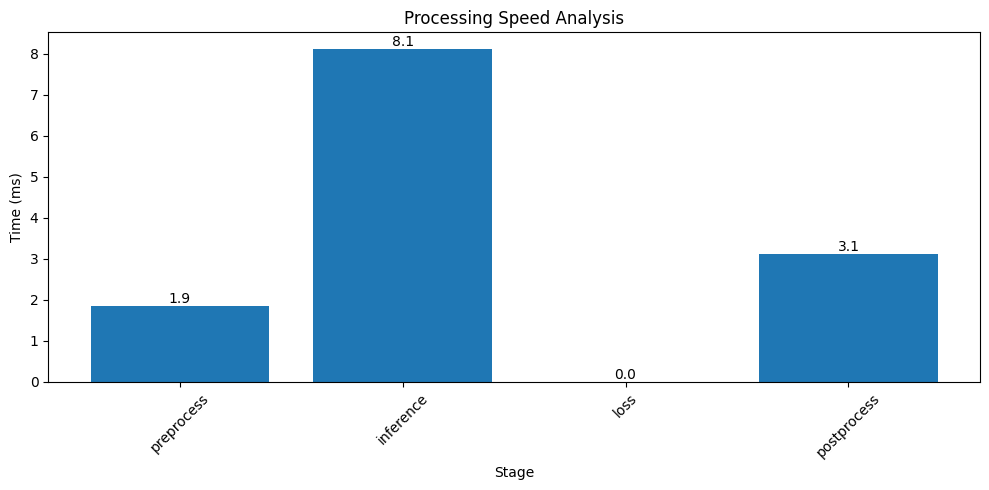

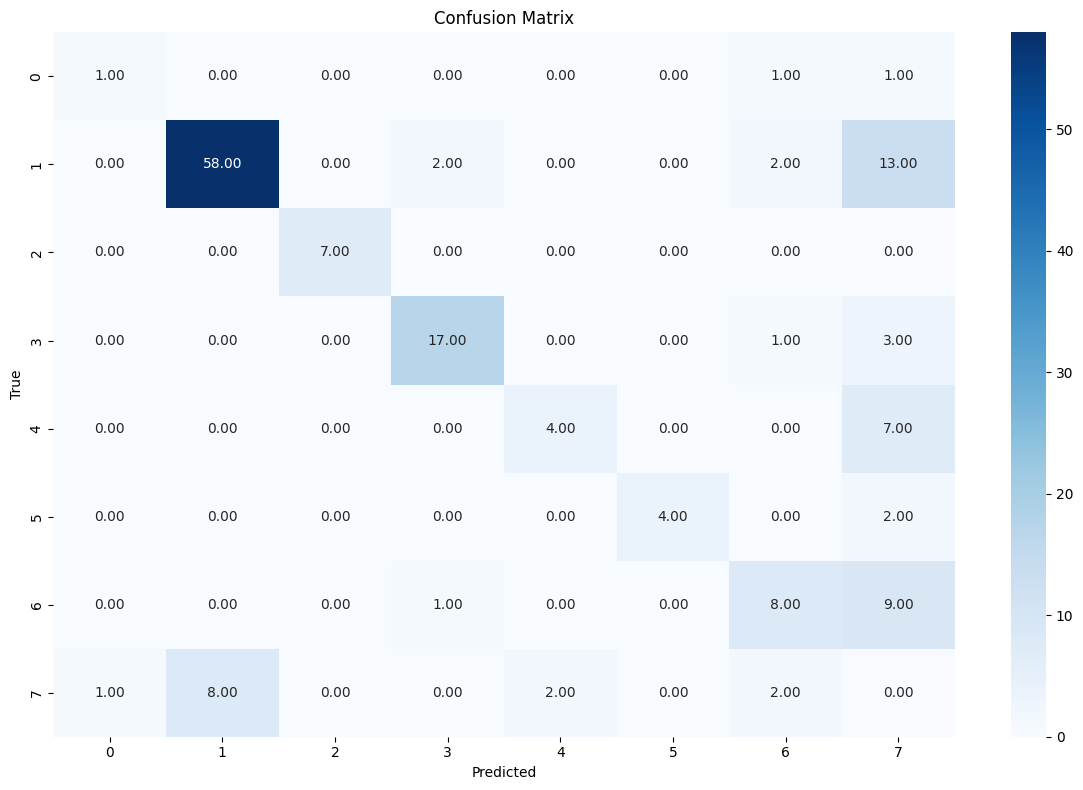

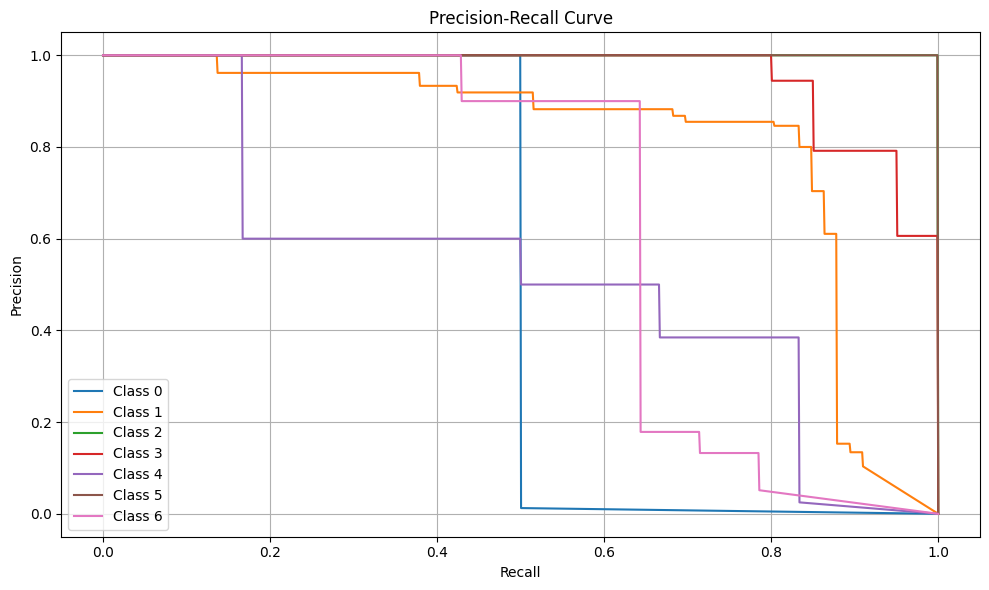

In [4]:
# Test YOLOv8 model
model_path = "runs/train/yolov8_exp_20250118_173358/weights/best.pt"
data_yaml_path = "data.yaml"

# Run testing
metrics_v8 = test_model(model_path, data_yaml_path)
save_results(metrics_v8, "yolov8")

### Testing YOLOv9 model


Testing model: runs/train/yolov9_exp_20250118_181530/weights/best.pt
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLOv9s summary (fused): 486 layers, 7,169,797 parameters, 0 gradients, 26.7 GFLOPs


val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.42s/it]


                   all         31        119        0.8      0.684      0.761      0.489
        Bacterial Spot          2          2       0.89        0.5        0.5       0.15
          Early_Blight         15         66      0.864      0.768      0.838      0.459
               Healthy          7          7      0.934          1      0.995       0.91
           Late_blight          9         20      0.942        0.7       0.94      0.629
             Leaf Mold          4          6      0.457      0.333      0.503      0.183
           Target_Spot          2          4      0.645          1      0.945      0.734
            black spot          9         14      0.872      0.486      0.602      0.356
Speed: 2.8ms preprocess, 23.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs\detect\val5

Performance Metrics:
mAP50: 0.761
mAP50-95: 0.489


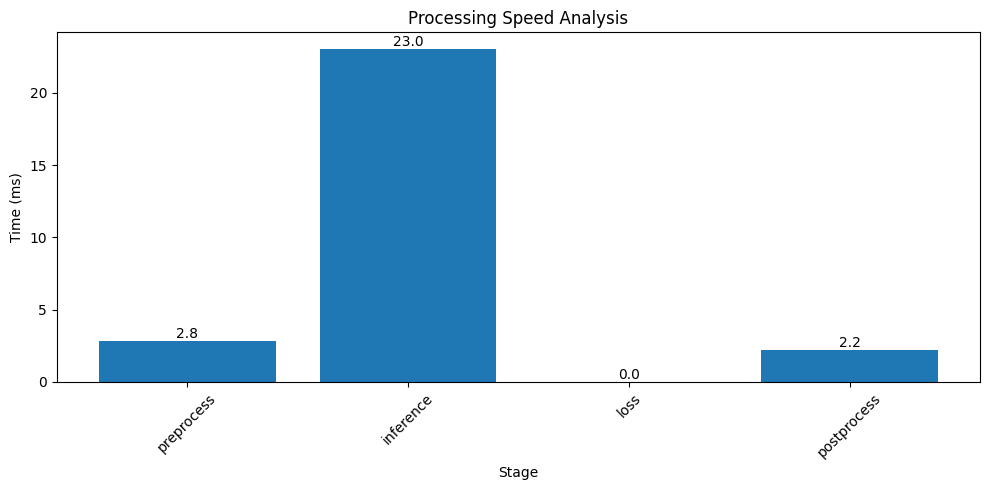

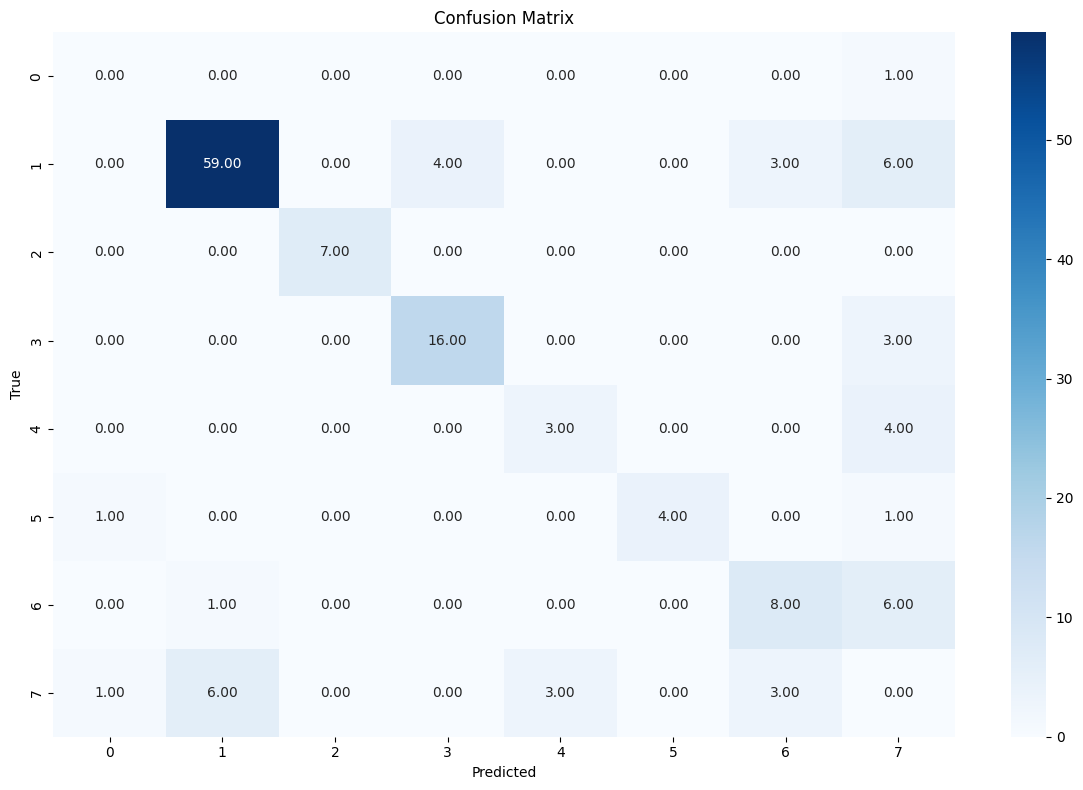

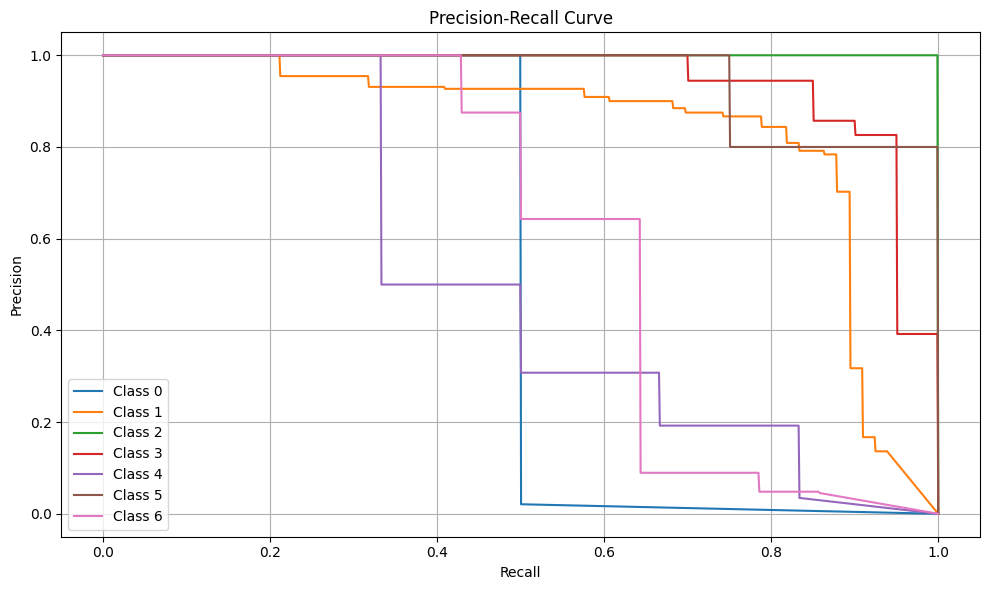

In [5]:
# Test YOLOv9 model
model_path = "runs/train/yolov9_exp_20250118_181530/weights/best.pt"  # Change this path
data_yaml_path = "data.yaml"

# Run testing
metrics_v9 = test_model(model_path, data_yaml_path)
save_results(metrics_v9, "yolov9")


Testing model: runs/train/yolov11_exp_20250118_201956/weights/best.pt
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11s summary (fused): 238 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.46s/it]


                   all         31        119      0.708      0.731      0.734      0.466
        Bacterial Spot          2          2      0.419        0.5      0.255     0.0552
          Early_Blight         15         66      0.805      0.818      0.849      0.455
               Healthy          7          7      0.923          1      0.995      0.929
           Late_blight          9         20       0.88        0.8      0.891      0.579
             Leaf Mold          4          6      0.595        0.5      0.544      0.189
           Target_Spot          2          4      0.613          1      0.995      0.716
            black spot          9         14      0.723        0.5      0.608       0.34
Speed: 3.1ms preprocess, 12.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\val6

Performance Metrics:
mAP50: 0.734
mAP50-95: 0.466


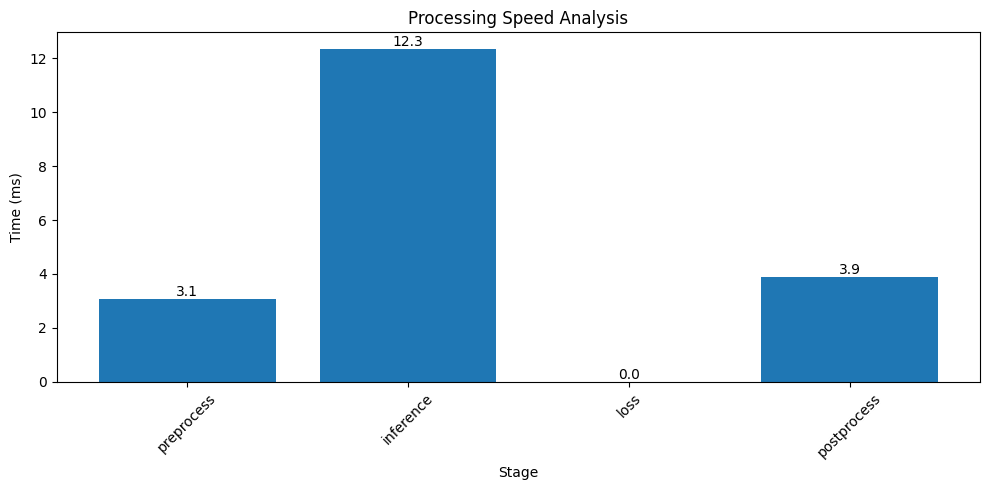

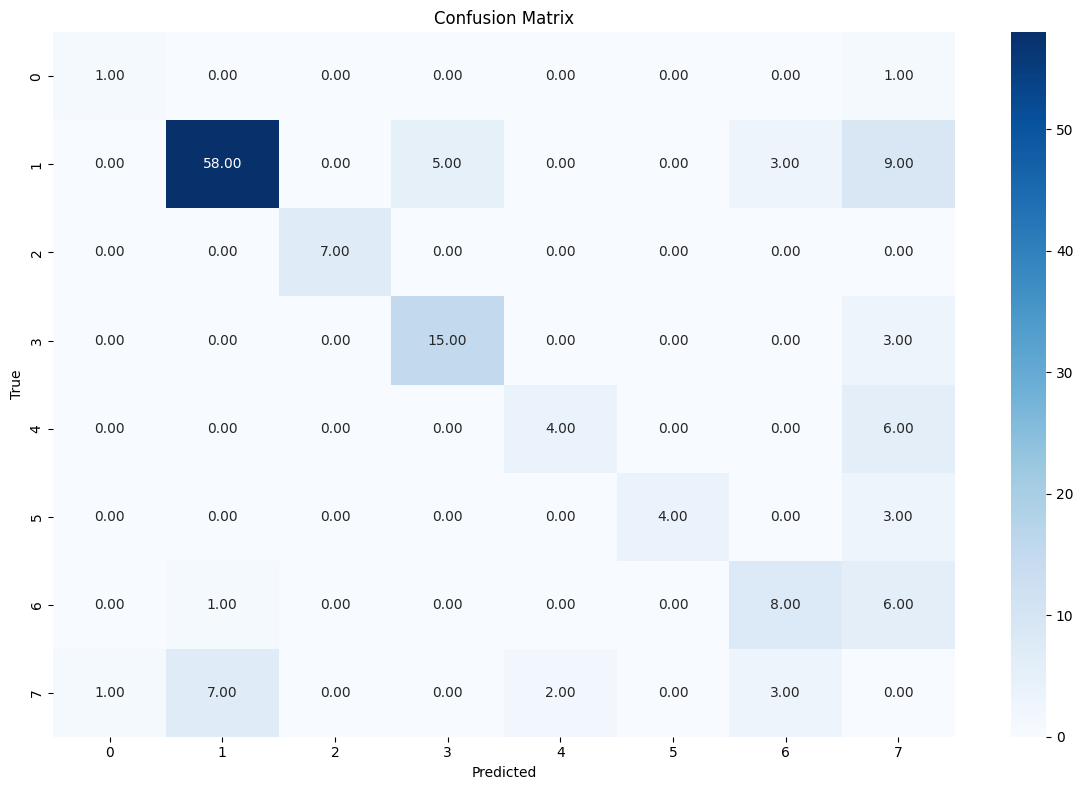

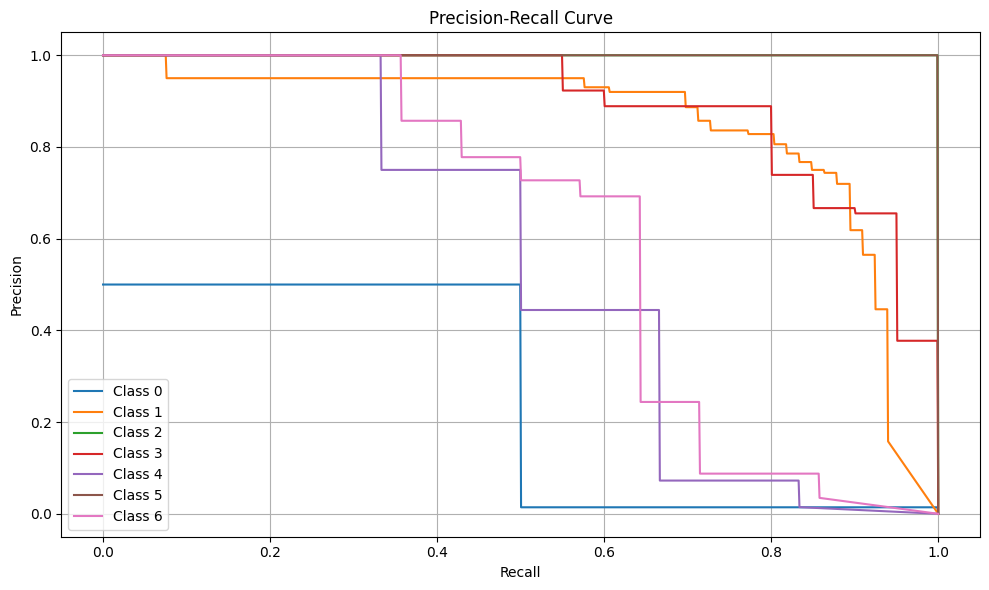

In [6]:
# Test YOLO11 model
model_path = "runs/train/yolov11_exp_20250118_201956/weights/best.pt"  # Change this path
data_yaml_path = "data.yaml"

# Run testing
metrics_11 = test_model(model_path, data_yaml_path)
save_results(metrics_11, "yolov11")

# Model Comparison: Visual Analysis

- Sample: 5 random test images
- Models: YOLOv8, YOLOv9, YOLOv11
- Visualization: Side-by-side comparison
- Metrics: Confidence scores and class predictions

In [15]:
# Class names
CLASS_NAMES = {
    0: 'Bacterial Spot',
    1: 'Early Blight',
    2: 'Healthy',
    3: 'Late Blight',
    4: 'Leaf Mold',
    5: 'Target Spot',
    6: 'Black Spot'
}

# Define colors for each class for consistent visualization
CLASS_COLORS = {
    0: '#FF0000',
    1: '#00FF00',
    2: '#0000FF',
    3: '#FFD700',
    4: '#FF69B4',
    5: '#4B0082',
    6: '#800000'
}

def compare_model_predictions(model_paths, test_image_paths, confidence=0.25):
    """
    Compare predictions from multiple models on test images and analyze class distributions
    """
    # Dictionary to store class predictions for each model
    class_predictions = {name: {i: 0 for i in CLASS_NAMES.keys()} 
                        for name in model_paths.keys()}
    total_predictions = {name: 0 for name in model_paths.keys()}
    
    # Load models
    models = {name: YOLO(path) for name, path in model_paths.items()}
    
    # Process each test image
    for img_path in test_image_paths:
        plt.figure(figsize=(20, 5))
        plt.suptitle(f'Model Comparison: {Path(img_path).name}', size=14)
        
        # Process with each model
        for idx, (name, model) in enumerate(models.items(), 1):
            results = model.predict(img_path, conf=float(confidence))[0]
            
            # Update class predictions
            for box in results.boxes:
                cls = int(box.cls[0].cpu().numpy())
                class_predictions[name][cls] += 1
                total_predictions[name] += 1
            
            # Plot results
            plt.subplot(1, 3, idx)
            plt.imshow(cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB))
            
            # Draw predictions
            for box in results.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = float(box.conf[0].cpu().numpy())
                cls = int(box.cls[0].cpu().numpy())
                
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                  fill=False, 
                                  color=CLASS_COLORS[cls],
                                  linewidth=2)
                plt.gca().add_patch(rect)
                
                label = f'{CLASS_NAMES[cls]}: {conf:.2f}'
                plt.text(x1, y1-5, label, 
                        color=CLASS_COLORS[cls],
                        fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.7))
            
            plt.title(f'{name}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Plot class distribution comparison
    plt.figure(figsize=(15, 6))
    
    # Prepare data for plotting
    models_data = []
    for model_name, predictions in class_predictions.items():
        model_dist = []
        total = total_predictions[model_name]
        for class_id in CLASS_NAMES.keys():
            percentage = (predictions[class_id] / total * 100) if total > 0 else 0
            model_dist.append(percentage)
        models_data.append(model_dist)
    
    # Bar plot
    x = np.arange(len(CLASS_NAMES))
    width = 0.25
    
    for i, (model_name, data) in enumerate(zip(models.keys(), models_data)):
        plt.bar(x + i*width, data, width, label=model_name)
    
    plt.xlabel('Classes')
    plt.ylabel('Percentage of Predictions')
    plt.title('Class Distribution Comparison Across Models')
    plt.xticks(x + width, CLASS_NAMES.values(), rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nDetailed Class Distribution Comparison:")
    print("-" * 60)
    print(f"{'Class':<20} {'YOLOv8':<10} {'YOLOv9':<10} {'YOLOv11':<10}")
    print("-" * 60)
    
    for class_id, class_name in CLASS_NAMES.items():
        percentages = []
        for model_name in models.keys():
            total = total_predictions[model_name]
            percentage = (class_predictions[model_name][class_id] / total * 100) if total > 0 else 0
            percentages.append(f"{percentage:.1f}%")
        print(f"{class_name:<20} {percentages[0]:<10} {percentages[1]:<10} {percentages[2]:<10}")
    
    print("-" * 60)
    print(f"{'Total Detections':<20}", end=" ")
    for model_name in models.keys():
        print(f"{total_predictions[model_name]:<10}", end=" ")
    print("\n")
    
    return class_predictions, total_predictions



image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0219_JPG.rf.c8d288f364390a28656a50ed7415713a.jpg: 640x640 1 Healthy, 13.4ms
Speed: 2.6ms preprocess, 13.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0219_JPG.rf.c8d288f364390a28656a50ed7415713a.jpg: 640x640 1 Healthy, 23.7ms
Speed: 3.1ms preprocess, 23.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0219_JPG.rf.c8d288f364390a28656a50ed7415713a.jpg: 640x640 1 Healthy, 17.7ms
Speed: 3.2ms preprocess, 17.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


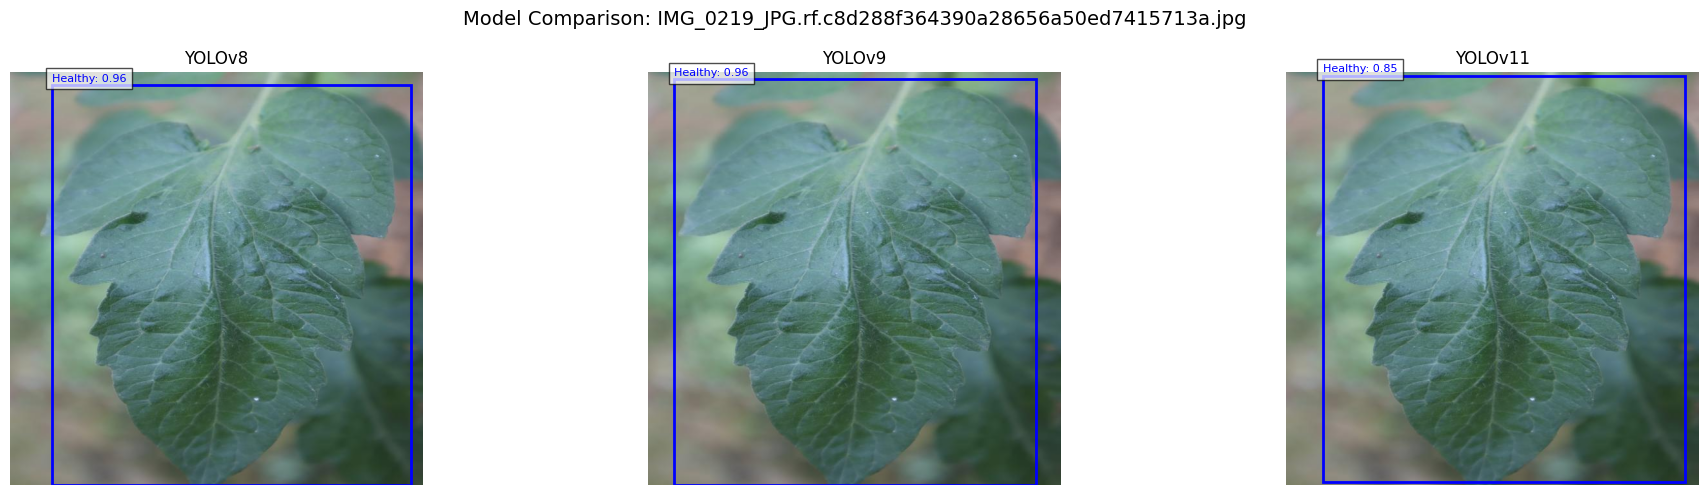


image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0577_JPG.rf.8f4955468e2ee47f88e50443943f45df.jpg: 640x640 6 Early_Blights, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0577_JPG.rf.8f4955468e2ee47f88e50443943f45df.jpg: 640x640 6 Early_Blights, 24.0ms
Speed: 2.4ms preprocess, 24.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0577_JPG.rf.8f4955468e2ee47f88e50443943f45df.jpg: 640x640 8 Early_Blights, 17.1ms
Speed: 2.3ms preprocess, 17.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


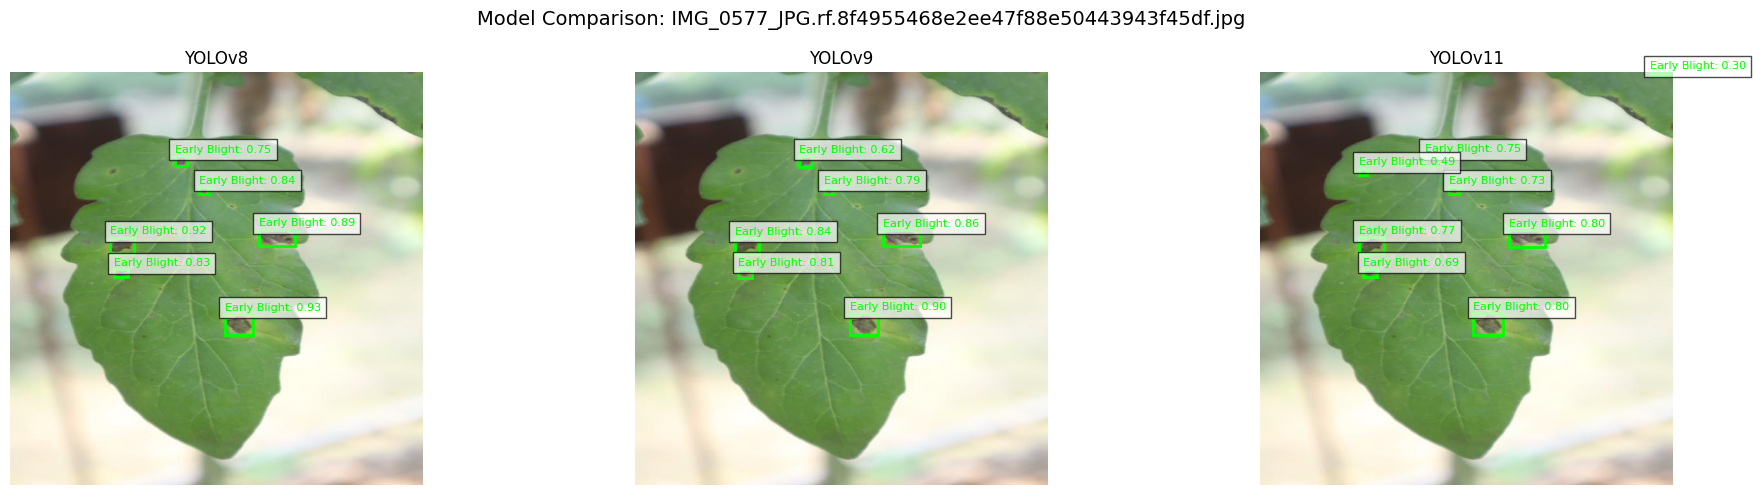


image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0300_JPG.rf.9294551b97cedde7e681b52876aed944.jpg: 640x640 1 Healthy, 16.0ms
Speed: 3.9ms preprocess, 16.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0300_JPG.rf.9294551b97cedde7e681b52876aed944.jpg: 640x640 1 Healthy, 38.8ms
Speed: 3.2ms preprocess, 38.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0300_JPG.rf.9294551b97cedde7e681b52876aed944.jpg: 640x640 1 Healthy, 16.9ms
Speed: 3.8ms preprocess, 16.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


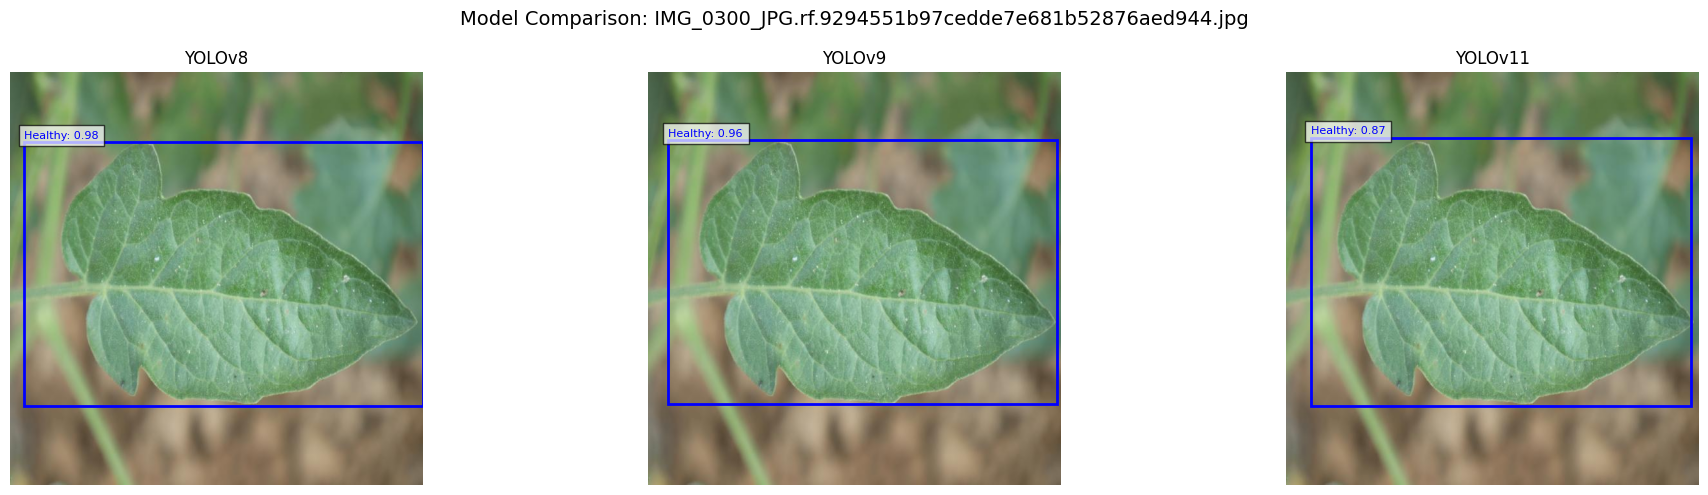


image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0361_JPG.rf.9df45f9f1d831bf0c30f3d62a2cd8b7a.jpg: 640x640 2 Target_Spots, 27.4ms
Speed: 3.3ms preprocess, 27.4ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0361_JPG.rf.9df45f9f1d831bf0c30f3d62a2cd8b7a.jpg: 640x640 2 Target_Spots, 26.5ms
Speed: 3.1ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_0361_JPG.rf.9df45f9f1d831bf0c30f3d62a2cd8b7a.jpg: 640x640 2 Target_Spots, 16.0ms
Speed: 3.5ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


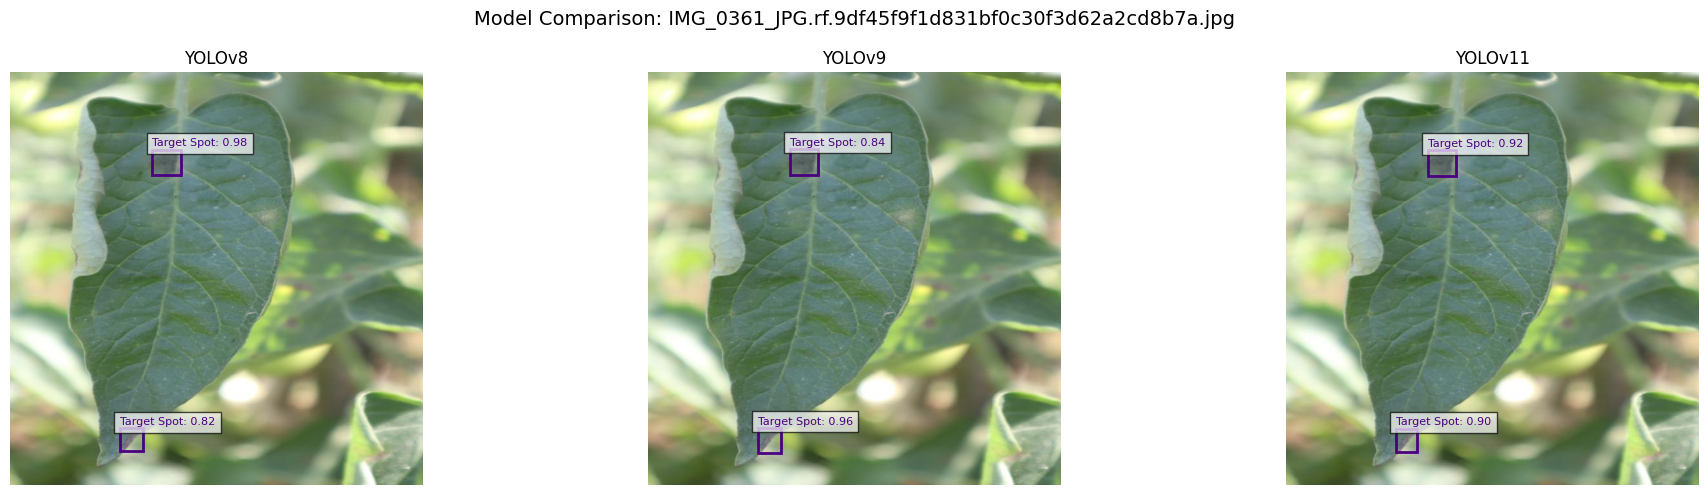


image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_1023_JPG.rf.6b85b647b5fc7f392b8b304c4c0f3422.jpg: 640x640 1 Healthy, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_1023_JPG.rf.6b85b647b5fc7f392b8b304c4c0f3422.jpg: 640x640 1 Healthy, 32.7ms
Speed: 3.1ms preprocess, 32.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\test\images\IMG_1023_JPG.rf.6b85b647b5fc7f392b8b304c4c0f3422.jpg: 640x640 1 Healthy, 27.3ms
Speed: 4.0ms preprocess, 27.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


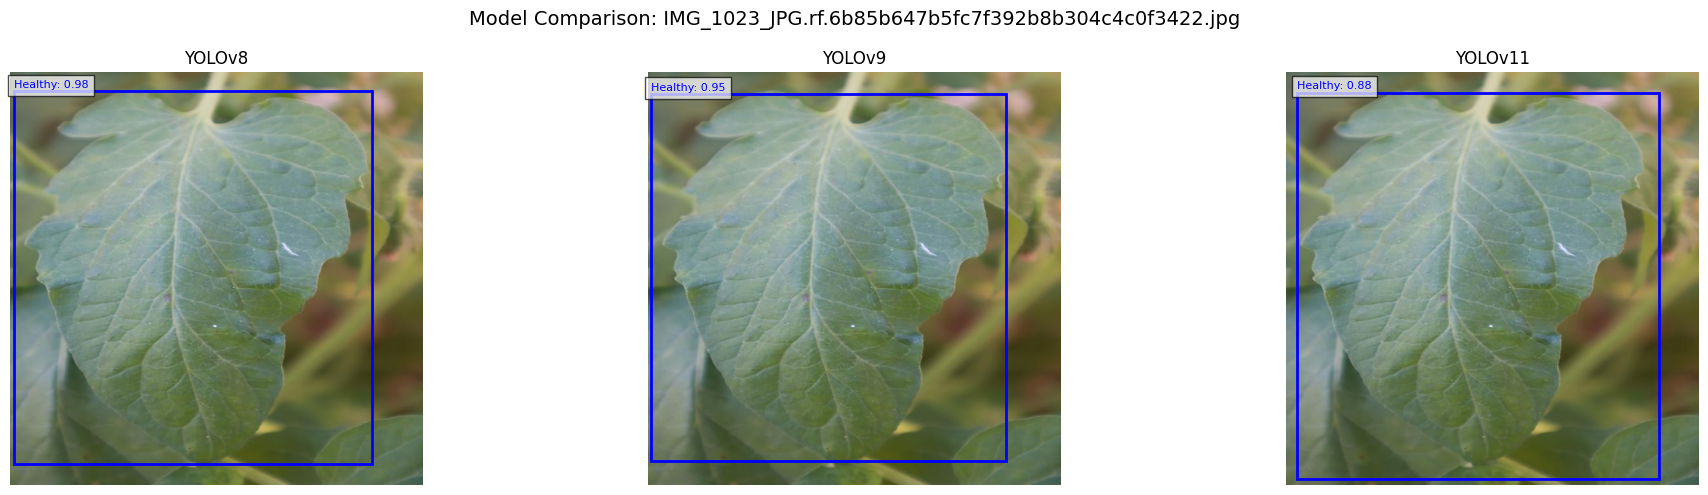

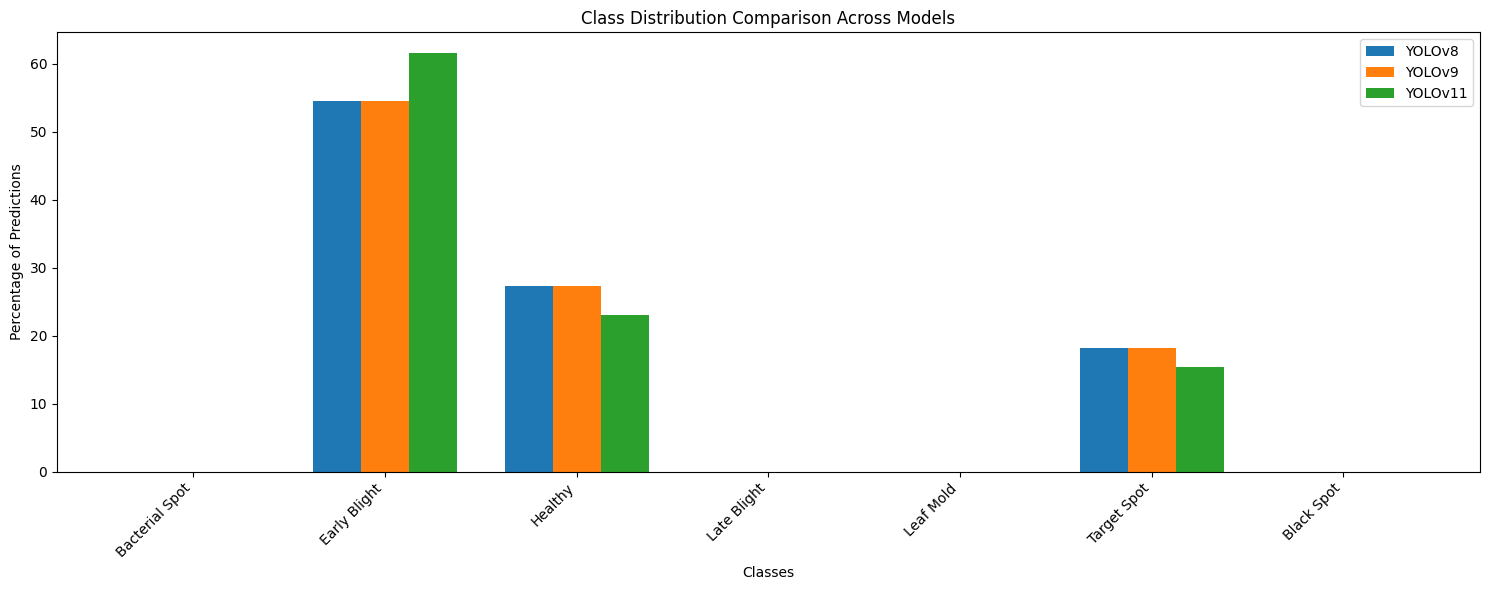


Detailed Class Distribution Comparison:
------------------------------------------------------------
Class                YOLOv8     YOLOv9     YOLOv11   
------------------------------------------------------------
Bacterial Spot       0.0%       0.0%       0.0%      
Early Blight         54.5%      54.5%      61.5%     
Healthy              27.3%      27.3%      23.1%     
Late Blight          0.0%       0.0%       0.0%      
Leaf Mold            0.0%       0.0%       0.0%      
Target Spot          18.2%      18.2%      15.4%     
Black Spot           0.0%       0.0%       0.0%      
------------------------------------------------------------
Total Detections     11         11         13         



In [ ]:
# Model paths
model_paths = {
    'YOLOv8': 'runs/train/yolov8_exp_20250118_173358/weights/best.pt',
    'YOLOv9': 'runs/train/yolov9_exp_20250118_181530/weights/best.pt',
    'YOLOv11': 'runs/train/yolov11_exp_20250118_201956/weights/best.pt'
}

# Number of test images
# Change n to see more class distribution analysis
n = 5

# Get n random test images
test_dir = Path('tomato-leaf-diseases/test/images')
test_images = list(test_dir.glob('*.jpg'))  # or *.png
random_test_images = random.sample(test_images, n)

# Run comparison
class_predictions, total_predictions = compare_model_predictions(model_paths, random_test_images)